In [125]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np 
import matplotlib.pyplot as plt
import time

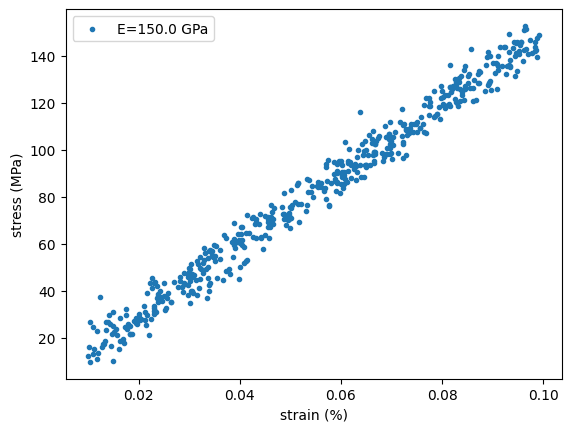

In [126]:
## Generate Hooke's law data with some noise
train_strain = np.random.uniform(0.01,0.10,500).astype("float32")		 			# in percentage
E = 150000.0				 														# in MPa
train_stress = E*train_strain*0.01 + np.random.normal(0,5,500).astype("float32")	# in MPa

plt.scatter(train_strain,train_stress,marker=".",label=f"E={E/1000} GPa")
plt.legend()
plt.xlabel("strain (%)")
plt.ylabel("stress (MPa)")
plt.show()
plt.close()	


In [127]:
class nnHookes(nn.Module):
	"""A simple neural network (multi layer perceptron with two hidden layers) to learn the dynamics of Hooke's law"""
	def __init__(self):
		super(nnHookes, self).__init__()
		self.fc1 = nn.Linear(1,64)
		self.fc2 = nn.Linear(64,64)
		self.fc3 = nn.Linear(64,1)

	def forward(self, x):
		x = torch.unsqueeze(x,1)
		act1 = F.leaky_relu(self.fc1(x),0.2)
		act2 = F.leaky_relu(self.fc2(act1),0.2)
		out = self.fc3(act2)
		
		return out, act1, act2

Epoch 0 completed in 0.05133175849914551secs.	 TL = 6316.205078125
Epoch 1 completed in 0.036550045013427734secs.	 TL = 1431.008544921875
Epoch 2 completed in 0.03371882438659668secs.	 TL = 8493.7685546875
Epoch 3 completed in 0.0291898250579834secs.	 TL = 4233.7216796875
Epoch 4 completed in 0.03241395950317383secs.	 TL = 4556.51904296875
Epoch 5 completed in 0.03379678726196289secs.	 TL = 2146.826904296875
Epoch 6 completed in 0.03165698051452637secs.	 TL = 1956.6815185546875
Epoch 7 completed in 0.031221866607666016secs.	 TL = 1616.4833984375
Epoch 8 completed in 0.029027700424194336secs.	 TL = 1129.6927490234375
Epoch 9 completed in 0.0288698673248291secs.	 TL = 1538.7109375
Epoch 10 completed in 0.028733253479003906secs.	 TL = 1786.1693115234375
Epoch 11 completed in 0.031084775924682617secs.	 TL = 2164.37255859375
Epoch 12 completed in 0.030304908752441406secs.	 TL = 2356.699951171875
Epoch 13 completed in 0.029562711715698242secs.	 TL = 1348.85986328125
Epoch 14 completed in 0.0

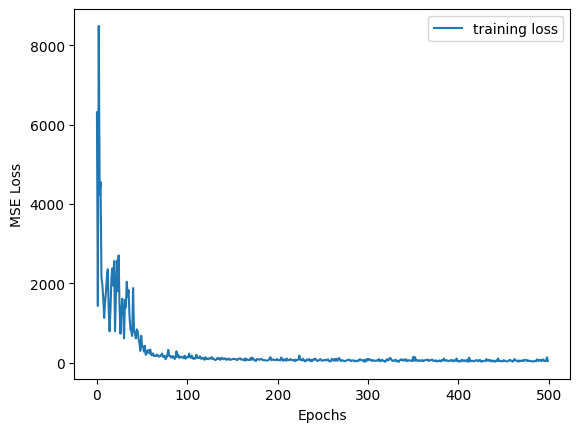

In [138]:
## Training the model
exp = "nnHookesLaw"

## training hyperparameters
epochs = 500
batch = 16
lr = 0.001
lambda1 = 0.5 			# for L1 regularization

## dataloaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(train_strain),torch.from_numpy(train_stress)),batch_size=batch,shuffle=True)

## optimizer
model = nnHookes()
optim = torch.optim.Adam(model.parameters(), lr)

## loss function
loss_func = nn.MSELoss()

model.train()
losslist = []

## training loop
for ep in range(epochs):
	t1 = time.time()
	for x,y in train_loader:
		optim.zero_grad()
		out, act1, act2 = model(x)
		loss = loss_func(y,out.squeeze()) + lambda1 * (torch.norm(act1,1) + torch.norm(act2,1))
		loss.backward()
		optim.step()
	print(f"Epoch {ep} completed in {time.time()-t1}secs.\t TL = {loss.item()}")
	losslist.append(loss.item())

plt.plot(losslist,label="training loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()
plt.close()

model.eval()
torch.save(model,f"./saved_model/{exp}.pt")


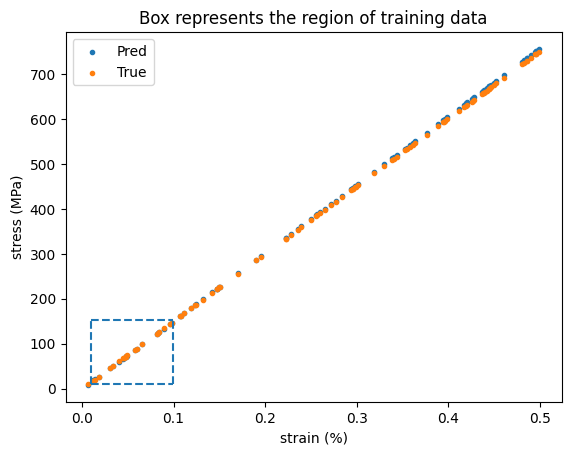

In [137]:
## Inference from the trained model

## generating test data
test_strain = torch.from_numpy(np.random.uniform(0.005,0.5,100).astype("float32"))	 		# in percentage
E = 150000.0								 												# in MPa
true_stress = E*test_strain*0.01															# in MPa
pred_stress,_,_ = model(test_strain)														# in MPa

test_strain = test_strain.detach().numpy()
true_stress = true_stress.detach().numpy()
pred_stress = pred_stress.detach().numpy()

train_stress_range = [np.min(train_stress),np.max(train_stress)]
train_strain_range = [np.min(train_strain),np.max(train_strain)]


plt.scatter(test_strain,pred_stress,marker=".",label=f"Pred")
plt.scatter(test_strain,true_stress,marker=".",label=f"True")
plt.vlines(x=train_strain_range[0],ymin=train_stress_range[0],ymax=train_stress_range[1],linestyles="dashed")
plt.vlines(x=train_strain_range[1],ymin=train_stress_range[0],ymax=train_stress_range[1],linestyles="dashed")
plt.hlines(y=train_stress_range[0],xmin=train_strain_range[0],xmax=train_strain_range[1],linestyles="dashed")
plt.hlines(y=train_stress_range[1],xmin=train_strain_range[0],xmax=train_strain_range[1],linestyles="dashed")
plt.legend()
plt.title("Box represents the region of training data")
plt.xlabel("strain (%)")
plt.ylabel("stress (MPa)")
plt.savefig("with_regularization.png")
plt.show()
plt.close()	
